To do list and doubts:

- usar label encoder ou onehotencoder? ou uma mistura dos dois
- matriz de correlação, apesar dos valores estarem grandes em algumas colunas, não acredito que a gente deve tirar algo por conta disso.
- usei muitos fills para consertar as colunas mistas (existem colunas mistas no sentido de que são mistura entre int, float e str (usualmente são valores 'normal' escrito))
    - substitui os valores que são 'normal' para valores medianos para dar fill e ficar a coluna somente com um tipo de variável
- as colunas que são relacionadas a 'preço' são normalmente erradas em termos naturais, "listing.pricingInfo.yearlyIptu", "listing.pricingInfo.rentalPrice", "listing.pricingInfo.monthlyCondoFee". Uma normalização apenas resolveria isso? Talvez sim, mas fico em duvida sobre a realidade dos valores, pois por exemplo listing.pricingInfo.monthlyCondoFee varia entre 1.0 a 990.0, mas faz sentido ser esses valores?
- testar tecnicas de normalização (normalização ou padronização dos dados depois de transformar as colunas categoricas em numericas)
- imvl_type vs. listing.unitTypes

Este é um trabalho em grupo de no máximo 5 participantes. Cada participante deverá enviar o trabalho completo individualmente pelo Classroom.

Descrição do trabalho de desenvolvimento das tarefas de regressão e classificação sobre dados de imóveis coletados a partir da web:

Este trabalho tem como objetivo desenvolver tarefas de regressão e classificação sobre dados de imóveis coletados a partir da web por meio do uso de webscraping. Os alunos podem utilizar este coletor de dados, disponível em https://github.com/serpaandre/ScrapZAP/blob/master/scrap_zap_v2.py como base para coleta de novos dados do site ZAP.

Utilizaremos os dados disponíveis no repositório https://www.kaggle.com/datasets/maverickjpa/brazilian-real-estate-to-rent e também vamos incrementar esse dataset com novos dados coletados por meio de webscraping. 

A tarefa de regressão consiste em prever o valor de venda de um imóvel. Para isso, utilizaremos os modelos de knn, regressão linear e regressão logística, além de outros modelos que não foram apresentados em sala de aula. A avaliação dos modelos será feita com base no cálculo do erro médio quadrático (MSE) e do coeficiente de determinação (R²), que são medidas comuns para avaliar a precisão de modelos de regressão.

Para a tarefa de classificação, criaremos um novo atributo que mapeia os valores de venda de imóveis em três padrões: BAIXO, MÉDIO e ALTO. Utilizaremos modelos de arvore de decisão para a tarefa de classificação, bem como outros modelos que não foram apresentados em sala de aula. A avaliação dos modelos será feita com base na acurácia e na matriz de confusão.
O prazo para a entrega do trabalho é de 3 semanas. Durante esse período, os alunos devem coletar novos dados de imóveis por meio de webscraping, a fim de incrementar o dataset disponível. É importante lembrar que os dados devem ser pré-processados, tratados e normalizados antes de serem utilizados nos modelos de regressão e classificação.

Espera-se que os alunos desenvolvam habilidades de programação em Python e familiaridade com técnicas de regressão e classificação. O trabalho é uma oportunidade para aplicar conceitos e teorias estudados em sala de aula em um problema real, além de fomentar a criatividade e a inovação na solução de problemas. O sucesso do trabalho dependerá do empenho e dedicação dos alunos em cada etapa do processo.

Adição: Cada equipe deve fazer um vídeo de até 15 minutos, com TODOS da equipe, explicando o notebook que foi feito (gravando apenas a tela). E enviar junto do notebook aqui pelo google classroom.

A nota para este trabalho será contabilizada da seguinte forma:

(4,0) Coleta e tratamento dos dados, incluindo webscraping
(4,0) Treinamento dos modelos RL, RLog, KNN, Arvore
(2,0) Avaliação dos resultados e ajustes

(1,0) BONUS - novos modelos treinados e avaliados

In [833]:
import pandas as pd
import numpy as np
import nb_black
import os
import warnings
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    log_loss,
)

from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso,
    ElasticNet,
)
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor

warnings.filterwarnings("ignore")

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


## Métodos

Essa secao ficara todos os metodos e funçoes que serao utilizadas no projeto, a fim de deixar mais organizado e limpo para facilitar o entendimento

In [545]:
def print_shape_dfs(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]

    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        df = pd.read_csv(filepath, delimiter=";")
        print(f"{file} -> {df.shape}")

In [546]:
def concat_csv_files(folder_path):
    files = os.listdir(folder_path)
    csv_files = [f for f in files if f.endswith(".csv")]
    print_shape_dfs(folder_path)

    dfs = []
    for file in csv_files:
        filepath = os.path.join(folder_path, file)
        temp_df = pd.read_csv(filepath, delimiter=";")
        dfs.append(temp_df)

    df_kaggle = pd.read_csv("dataZAP.csv", delimiter=";")
    dfs.append(df_kaggle)

    all_columns = set().union(*[set(df.columns) for df in dfs])
    dfs = [df.reindex(columns=all_columns) for df in dfs]

    result = pd.concat(dfs, ignore_index=True)
    output_file = os.path.join("./", "dataZap_concatenated.csv")
    result.to_csv(output_file, sep=";", index=False)
    print(f"Shape do df inicial: {df_kaggle.shape}\nShape do df final: {result.shape}")

In [547]:
def check_columns(df):
    check = []
    for column in df.columns:
        types = df[column].apply(type).unique()
        if len(types) > 1:
            if pd.api.types.is_numeric_dtype(df[column]):
                try:
                    converted = pd.to_numeric(df[column], errors="raise")
                except ValueError:
                    check.append(column)
            else:
                check.append(column)

    return check

In [548]:
def remove_outliers(df, num_columns):
    for column in num_columns:
        Q1 = np.percentile(df[column], 25)
        Q3 = np.percentile(df[column], 75)
        IQR = Q3 - Q1

        threshold = 1.5
        lower_limit = Q1 - threshold * IQR
        upper_limit = Q3 + threshold * IQR

        df = df[(df[column] > lower_limit) & (df[column] < upper_limit)]

    return df

In [549]:
def encode_categorical_columns(df, cat_columns):
    encoded_df = df.copy()

    for column in cat_columns:
        encoded_columns = pd.get_dummies(df[column], prefix=column)
        encoded_df = pd.concat([encoded_df, encoded_columns], axis=1)
        encoded_df.drop(column, axis=1, inplace=True)

    return encoded_df

In [550]:
def standardize_columns(df, num_columns):
    standardized_df = df.copy()

    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    standardized_columns = scaler.fit_transform(df[num_columns])
    standardized_df[num_columns] = standardized_columns

    return standardized_df

In [551]:
def evaluate_metrics(actual, pred):
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    R2_score = r2_score(actual, pred)
    print("Model testing performance:")
    print("--------------------------")
    print(f"R2_score \t: {round(R2_score, 4)}")
    print(f"MAE \t\t: {round(mae, 4)}")
    print(f"MSE \t\t: {round(mse, 4)}")
    print(f"RMSE \t\t: {round(rmse, 4)}")

In [834]:
def evaluate_metrics_cv(model, X_train, y_train, X_test, y_test):
    cv_score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=10)

    if isinstance(model, LinearRegression):
        y_pred = model.predict(X_test)

        R2 = model.score(X_test, y_test)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        MAE = mean_absolute_error(y_test, y_pred)

        CV_RMSE = np.sqrt(
            -cross_val_score(
                estimator=model,
                X=X_train,
                y=y_train,
                cv=10,
                scoring="neg_mean_squared_error",
            ).mean()
        )
        CV_MAE = -cross_val_score(
            estimator=model,
            X=X_train,
            y=y_train,
            cv=10,
            scoring="neg_mean_absolute_error",
        ).mean()

        return ("Linear Regression", R2, cv_score.mean(), RMSE, CV_RMSE, MAE, CV_MAE)

    elif isinstance(model, LogisticRegression):
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        accuracy = model.score(X_test, y_test)
        logloss = log_loss(y_test, y_pred_proba)

        CV_accuracy = cv_score.mean()
        CV_logloss = -cross_val_score(
            estimator=model, X=X_train, y=y_train, cv=10, scoring="neg_log_loss"
        ).mean()

        return ("Logistic Regression", accuracy, CV_accuracy, logloss, CV_logloss)

    elif isinstance(
        model, (Ridge, Lasso, ElasticNet, KNeighborsRegressor, DecisionTreeRegressor)
    ):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        R2 = r2_score(y_test, y_pred)
        RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
        MAE = mean_absolute_error(y_test, y_pred)

        CV_RMSE = np.sqrt(
            -cross_val_score(
                estimator=model,
                X=X_train,
                y=y_train,
                cv=10,
                scoring="neg_mean_squared_error",
            ).mean()
        )
        CV_MAE = -cross_val_score(
            estimator=model,
            X=X_train,
            y=y_train,
            cv=10,
            scoring="neg_mean_absolute_error",
        ).mean()

        return (type(model).__name__, R2, cv_score.mean(), RMSE, CV_RMSE, MAE, CV_MAE)

## Webscraping

### Pre-Incrementação

Essa análise abaixo foi necessária para que nosso script de webscraping tenha as mesmas colunas e formato do dataset que está no kaggle, então abaixo foi feito uma análise sobre o shape deles e também sobre quais colunas tem em um e que não tem no outro, até que se chegou no ponto final, que é quando as duas tem o mesmo shape e colunas iguais, que é o output dessa parte.

Isso impactou no código scrap_zap_v3 (nossa versão), pois tive que modificar as colunas que são filtradas e consequentemente criadas o dataframe.

dfc = dataset do kaggle

dfx = um dos datasets que o webscraping cria

In [553]:
df = pd.read_csv("dataZAP.csv", delimiter=";")
df.shape

(35772, 78)

In [81]:
df_aux = pd.read_csv(
    "webscraping-datasets/dataZap_ce_aluguel_casas_TODOS_3.csv", delimiter=";"
)
df_aux.shape

(352, 78)

In [82]:
dfc = []
for i in df.columns:
    dfc.append(i)

dfx = []
for i in df_aux.columns:
    dfx.append(i)

dfc = set(dfc)
dfx = set(dfx)

In [83]:
len(dfc.intersection(dfx))

78

In [84]:
list(dfc - dfx)

[]

In [85]:
list(dfx - dfc)

[]

Conclusao: Dessa forma final, todas os dataframes que forem realizados pelo webscraping terao as mesmas colunas e quantidades que o dataset do kaggle, facilitando a incrementacao dos dados via scraping.

### Utilização do Script de WebScraping

O site do ZAP tem uma 'proteção' http por scraping, então o excesso de requisições ele acaba bloqueando por alguns minutos para uma outra nova requisição 

In [86]:
!python ./webscraping/scrap_zap_v3.py

^C


### Incrementação do Dataset

In [87]:
concat_csv_files("webscraping-datasets")

dataZap_ba_aluguel_casas_TODOS_3.csv -> (495, 78)
dataZap_ce_aluguel_casas_TODOS_3.csv -> (352, 78)
dataZap_es_aluguel_casas_TODOS_3.csv -> (106, 78)
dataZap_mg_aluguel_casas_TODOS_3.csv -> (1727, 78)
dataZap_rj_aluguel_apartamentos_TODOS_2.csv -> (8301, 78)
dataZap_rj_aluguel_apartamentos_TODOS_3.csv -> (4126, 78)
dataZap_rj_aluguel_apartamentos_TODOS_4.csv -> (1565, 78)
dataZap_rj_aluguel_apartamentos_TODOS_5.csv -> (107, 78)
dataZap_rj_aluguel_casas_TODOS_3.csv -> (1227, 78)
dataZap_rj_aluguel_casas_TODOS_5.csv -> (449, 78)
dataZap_rj_aluguel_cobertura_TODOS_2.csv -> (217, 78)
dataZap_rj_aluguel_cobertura_TODOS_3.csv -> (590, 78)
dataZap_rj_aluguel_cobertura_TODOS_4.csv -> (643, 78)
dataZap_sp_aluguel_casas_TODOS_3.csv -> (8900, 78)
Shape do df inicial: (35772, 78)
Shape do df final: (64577, 78)


## Data Science

### Pre-processamento

In [715]:
df = pd.read_csv("dataZap_concatenated.csv", delimiter=";")

In [716]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64577 entries, 0 to 64576
Data columns (total 78 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   listing.usageTypes                    64577 non-null  object 
 1   listing.pricingInfo.period            64577 non-null  object 
 2   listing.playground                    64577 non-null  bool   
 3   account.licenseNumber                 57489 non-null  object 
 4   listing.address.confidence            64577 non-null  object 
 5   listing.address.neighborhood          64501 non-null  object 
 6   listing.preview                       64577 non-null  bool   
 7   listing.unitTypes                     64577 non-null  object 
 8   listing.address.precision             64577 non-null  object 
 9   listing.parkingSpaces                 63002 non-null  object 
 10  listing.bathtub                       64577 non-null  bool   
 11  listing.pricing

In [717]:
df.describe()

,listing.bedrooms,listing.pricingInfo.rentalPrice,listing.id,listing.unitFloor,listing.unitsOnTheFloor
count,64577.000000,64577.000000,6.457700e+04,64577.000000,64577.000000
mean,2.558806,104.100266,2.507029e+09,0.426917,0.312015
std,1.097265,255.756548,2.105493e+08,1.945242,1.669723
min,0.000000,1.000000,4.346026e+07,0.000000,0.000000
25%,2.000000,2.000000,2.480232e+09,0.000000,0.000000
50%,3.000000,3.800000,2.490048e+09,0.000000,0.000000
75%,3.000000,10.000000,2.616321e+09,0.000000,0.000000
max,20.000000,999.000000,2.632962e+09,102.000000,52.000000


In [718]:
df.head()

,listing.usageTypes,listing.pricingInfo.period,listing.playground,account.licenseNumber,listing.address.confidence,listing.address.neighborhood,listing.preview,listing.unitTypes,listing.address.precision,listing.parkingSpaces,listing.bathtub,listing.pricingInfo.price,listing.updatedAt,listing.gym,listing.isInactive,listing.floors,listing.barbgrill,listing.listingType,listing.subtitle,listing.totalAreas,listing.address.point.lon,listing.pricingInfo.yearlyIptu,listing.bathrooms,listing.fireplace,type,listing.bedrooms,listing.description,listing.advertiserId,listing.address.city,listing.pricingInfo.businessType,listing.pricingInfo.rentalPrice,listing.portal,listing.address.country,listing.pricingInfo.rentalTotalPrice,listing.pricingInfo.businessLabel,listing.id,listing.tenniscourt,listing.amenities,listing.link,listing.externalId,listing.garden,listing.displayAddressType,listing.pricingInfo.salePrice,listing.address.zone,listing.usableAreas,listing.soundproofing,imvl_type,listing.acceptExchange,listing.hottub,listing.unitFloor,listing.address.level,listing.propertyType,listing.sauna,listing.furnished,listing.backyard,listing.address.zipCode,listing.guestpark,listing.mountainview,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.isRent,listing.legacyId,listing.pool,listing.createdAt,listing.partyhall,listing.address.state,listing.title,listing.publicationType,listing.sportcourt,listing.address.streetNumber,listing.address.point.lat,listing.pricingInfo.isSale,listing.unitsOnTheFloor,listing.address.street,listing.suites,listing.unitSubTypes,listing.businessTypeContext,account.name,listing.address.point.source
0,RESIDENTIAL,dia,False,NaN,VALID_STREET,Guarajuba Monte Gordo,False,HOME,APPROXIMATE,2.0,False,3.000,2023-01-12T08:50:05.990Z,False,False,NaN,True,USED,Casa para alugar em,900.0,NaN,NaN,5,False,superPremium,3,Sua ampla e super ventilada cozinha americana ...,04c372ee-f00e-7e39-3d53-90cfaa1a8ab2,Camaçari,RENTAL,3.0,GRUPOZAP,BR,NaN,Alugar,2552533354,True,DISABLED_ACCESS|BICYCLES_PLACE|PARKING|BARBECU...,/imovel/aluguel-casa-3-quartos-mobiliado-guara...,CO562A,True,STREET,NaN,Bairros,300,False,casas,False,False,0,CITY,UNIT,False,True,False,42840492.0,False,False,700.0,True,NaN,False,2022-02-22T19:17:45.103Z,True,Bahia,Casa para aluguel frente a praia em Guarajuba ...,SUPER_PREMIUM,True,NaN,NaN,False,0,Rua Arraia,3.0,NaN,RENTAL,Hansen Imóveis Ltda,NaN
1,RESIDENTIAL,mês,False,NaN,VALID_STREET,Nazaré,False,HOME,ROOFTOP,0.0,False,3.000,2023-05-05T10:02:17.022Z,False,False,NaN,False,USED,Casa para alugar em,183.0,NaN,161.0,3,False,superPremium,3,CASA DUPLEX<br><br>PRIMEIRO PAVIMENTO<br><br>0...,01a3699f-cd61-1e5b-591e-a5b91c00fc7e,Salvador,RENTAL,3.0,GRUPOZAP,BR,NaN,Alugar,2628408803,False,KITCHEN|INTERCOM|SERVICE_AREA,/imovel/aluguel-casa-3-quartos-com-cozinha-naz...,CA0218,False,NEIGHBORHOOD,NaN,Bairros,183,False,casas,False,False,0,STREET,UNIT,False,False,False,40050330.0,False,False,NaN,True,NaN,False,2023-04-26T00:14:08.546Z,False,Bahia,"Casa com 3 Dormitórios para Alugar, 183 m² por...",SUPER_PREMIUM,False,NaN,NaN,False,0,NaN,1.0,NaN,RENTAL,Adriana Silva dos Santos,NaN
2,RESIDENTIAL,mês,False,14268-J-BA,VALID_STREET,Pituba,False,HOME,GEOMETRIC_CENTER,7.0,False,7.500,2023-04-29T21:40:00.231Z,False,False,NaN,False,USED,Casa para alugar e comprar em,1000.0,-38.451315,260.0,3,False,superPremium,3,"Casa ampla , situado em uma rua residencial. p...",42074fd8-9c4d-fb59-a874-b1dcb90c6890,Salvador,RENTAL_SALE,7.5,GRUPOZAP,BR,NaN,Alugar/Comprar,2616700504,False,NaN,/imovel/venda-casa-3-quartos-pituba-salvador-b...,741,False,ALL,1.300.000,Bairros,300,False,casas,False,False,1,STREET,UNIT,False,False,False,41810680.0,False,False,NaN,True,NaN,False,2023-03-04T14:04:38.655Z,False,Bahia,Casa Ampla em Pituba - Salvador,SUPER_PREMIUM,False,NaN,-12.992829,True,0,Rua Anthenor Tupinambá,2.0,NaN,RENTAL,ISLV IMÓVEIS,GOOGLE
3,RESIDENTIAL,mês,False,NaN,VALID_STREET,Gleba A,False,HOME,ROOFTOP,2.0,False,1.800,2023-05-03T18:05:11.399Z,False,False,N

In [719]:
df.isna().sum()

listing.usageTypes                  0
listing.pricingInfo.period          0
listing.playground                  0
account.licenseNumber            7088
listing.address.confidence          0
                                ...  
listing.suites                   3074
listing.unitSubTypes            27927
listing.businessTypeContext         0
account.name                        0
listing.address.point.source    18865
Length: 78, dtype: int64

#### Analisando as colunas

In [720]:
columns = [
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
]
df[columns]

,listing.pricingInfo.isRent,listing.pricingInfo.isSale,listing.pricingInfo.price,listing.pricingInfo.rentalPrice,listing.pricingInfo.rentalTotalPrice,listing.pricingInfo.salePrice
0,True,False,3.000,3.00,NaN,NaN
1,True,False,3.000,3.00,NaN,NaN
2,True,True,7.500,7.50,NaN,1.300.000
3,True,False,1.800,1.80,NaN,NaN
4,True,False,1.800,1.80,NaN,NaN
...,...,...,...,...,...,...
64572,True,False,1.8,1.80,2.720,normal
64573,True,False,1.19,1.19,1.434,normal
64574,True,False,940.0,940.00,1.054,normal
64575,True,False,1.6,1.60,2.294,normal


In [721]:
df["listing.pricingInfo.rentalTotalPrice"].isna().sum()

13765

In [722]:
df["listing.pricingInfo.price"].isna().sum()

0

In [723]:
df[(df["listing.pricingInfo.isRent"] == True)]

,listing.usageTypes,listing.pricingInfo.period,listing.playground,account.licenseNumber,listing.address.confidence,listing.address.neighborhood,listing.preview,listing.unitTypes,listing.address.precision,listing.parkingSpaces,listing.bathtub,listing.pricingInfo.price,listing.updatedAt,listing.gym,listing.isInactive,listing.floors,listing.barbgrill,listing.listingType,listing.subtitle,listing.totalAreas,listing.address.point.lon,listing.pricingInfo.yearlyIptu,listing.bathrooms,listing.fireplace,type,listing.bedrooms,listing.description,listing.advertiserId,listing.address.city,listing.pricingInfo.businessType,listing.pricingInfo.rentalPrice,listing.portal,listing.address.country,listing.pricingInfo.rentalTotalPrice,listing.pricingInfo.businessLabel,listing.id,listing.tenniscourt,listing.amenities,listing.link,listing.externalId,listing.garden,listing.displayAddressType,listing.pricingInfo.salePrice,listing.address.zone,listing.usableAreas,listing.soundproofing,imvl_type,listing.acceptExchange,listing.hottub,listing.unitFloor,listing.address.level,listing.propertyType,listing.sauna,listing.furnished,listing.backyard,listing.address.zipCode,listing.guestpark,listing.mountainview,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.isRent,listing.legacyId,listing.pool,listing.createdAt,listing.partyhall,listing.address.state,listing.title,listing.publicationType,listing.sportcourt,listing.address.streetNumber,listing.address.point.lat,listing.pricingInfo.isSale,listing.unitsOnTheFloor,listing.address.street,listing.suites,listing.unitSubTypes,listing.businessTypeContext,account.name,listing.address.point.source
0,RESIDENTIAL,dia,False,NaN,VALID_STREET,Guarajuba Monte Gordo,False,HOME,APPROXIMATE,2.0,False,3.000,2023-01-12T08:50:05.990Z,False,False,NaN,True,USED,Casa para alugar em,900.0,NaN,NaN,5,False,superPremium,3,Sua ampla e super ventilada cozinha americana ...,04c372ee-f00e-7e39-3d53-90cfaa1a8ab2,Camaçari,RENTAL,3.00,GRUPOZAP,BR,NaN,Alugar,2552533354,True,DISABLED_ACCESS|BICYCLES_PLACE|PARKING|BARBECU...,/imovel/aluguel-casa-3-quartos-mobiliado-guara...,CO562A,True,STREET,NaN,Bairros,300,False,casas,False,False,0,CITY,UNIT,False,True,False,42840492.0,False,False,700.0,True,NaN,False,2022-02-22T19:17:45.103Z,True,Bahia,Casa para aluguel frente a praia em Guarajuba ...,SUPER_PREMIUM,True,NaN,NaN,False,0,Rua Arraia,3.0,NaN,RENTAL,Hansen Imóveis Ltda,NaN
1,RESIDENTIAL,mês,False,NaN,VALID_STREET,Nazaré,False,HOME,ROOFTOP,0.0,False,3.000,2023-05-05T10:02:17.022Z,False,False,NaN,False,USED,Casa para alugar em,183.0,NaN,161.0,3,False,superPremium,3,CASA DUPLEX<br><br>PRIMEIRO PAVIMENTO<br><br>0...,01a3699f-cd61-1e5b-591e-a5b91c00fc7e,Salvador,RENTAL,3.00,GRUPOZAP,BR,NaN,Alugar,2628408803,False,KITCHEN|INTERCOM|SERVICE_AREA,/imovel/aluguel-casa-3-quartos-com-cozinha-naz...,CA0218,False,NEIGHBORHOOD,NaN,Bairros,183,False,casas,False,False,0,STREET,UNIT,False,False,False,40050330.0,False,False,NaN,True,NaN,False,2023-04-26T00:14:08.546Z,False,Bahia,"Casa com 3 Dormitórios para Alugar, 183 m² por...",SUPER_PREMIUM,False,NaN,NaN,False,0,NaN,1.0,NaN,RENTAL,Adriana Silva dos Santos,NaN
2,RESIDENTIAL,mês,False,14268-J-BA,VALID_STREET,Pituba,False,HOME,GEOMETRIC_CENTER,7.0,False,7.500,2023-04-29T21:40:00.231Z,False,False,NaN,False,USED,Casa para alugar e comprar em,1000.0,-38.451315,260.0,3,False,superPremium,3,"Casa ampla , situado em uma rua residencial. p...",42074fd8-9c4d-fb59-a874-b1dcb90c6890,Salvador,RENTAL_SALE,7.50,GRUPOZAP,BR,NaN,Alugar/Comprar,2616700504,False,NaN,/imovel/venda-casa-3-quartos-pituba-salvador-b...,741,False,ALL,1.300.000,Bairros,300,False,casas,False,False,1,STREET,UNIT,False,False,False,41810680.0,False,False,NaN,True,NaN,False,2023-03-04T14:04:38.655Z,False,Bahia,Casa Ampla em Pituba - Salvador,SUPER_PREMIUM,False,NaN,-12.992829,True,0,Rua Anthenor Tupinambá,2.0,NaN,RENTAL,ISLV IMÓVEIS,GOOGLE
3,RESIDENTIAL,mês,False,NaN,VALID_STREET,Gleba A,False,HOME,ROOFTOP,2.0,False,1.800,2023-05-03T18:05:11.399Z,False,Fals

In [724]:
df["listing.pricingInfo.businessType"].value_counts()

RENTAL         49276
RENTAL_SALE    13555
SALE_RENTAL     1746
Name: listing.pricingInfo.businessType, dtype: int64

In [725]:
df["listing.displayAddressType"].value_counts()

ALL             34986
STREET          19787
NEIGHBORHOOD     9804
Name: listing.displayAddressType, dtype: int64

In [726]:
df["listing.isInactive"].value_counts()

False    64018
True       559
Name: listing.isInactive, dtype: int64

In [727]:
df["listing.floors"].unique()  # Valores mistos que serão tratados

array([nan, 0.0, 1.0, 3.0, 2.0, 6.0, 12.0, 4.0, 17.0, 7.0, 8.0, 13.0,
       20.0, 10.0, 23.0, 15.0, 11.0, 14.0, 16.0, 5.0, 9.0, 24.0, 18.0,
       22.0, 19.0, 21.0, 25.0, 30.0, 29.0, 26.0, 28.0, 175.0, 71.0, 32.0,
       '0.0', '1.0', '12.0', '32.0', '22.0', '10.0', '28.0', '3.0', '2.0',
       '6.0', '14.0', '71.0', 'normal', '2', '21', '10', '13', '15', '12',
       '4', '20', '6', '8', '3', '11', '28', '23', '9', '16', '14', '24',
       '30', '5', '17', '22', '27', '19', '1', '7', '35', '18', '25',
       '26', '660', '175', '31', '32', '33'], dtype=object)

In [728]:
df["listing.totalAreas"].unique()  # Valores mistos que serão tratados

array([900.0, 183.0, 1000.0, ..., '1778', '3600', '1108'], dtype=object)

In [729]:
# Tirando as colunas que nao importam para nossa analise

columns = [
    "listing.address.streetNumber",
    "Page",
    "account.legacyVivarealId",
    "account.legacyZapId",
    "listing.address.geoJson",
    "account.licenseNumber",
    "listing.address.ibgeCityId",
    "listing.id",
    "listing.legacyId",
    "listing.pricingInfo.priceVariation",
    "listing.description",
    "listing.images",
    "listing.videos",
    "listing.pricingInfo.isRent",
    "listing.pricingInfo.isSale",
    "listing.pricingInfo.price",
    "listing.pricingInfo.rentalTotalPrice",
    "listing.pricingInfo.salePrice",
    "listing.unitSubTypes",
    "listing.amenities",
    "account.logoUrl",
    "account.name",
    "link.href",
    "listing.updatedAt",
    "listing.subtitle",
    "listing.title",
    "listing.portal",
    "listing.createdAt",
    "listing.externalId",
    "listing.advertiserId",
    "listing.address.street",
    "listing.address.point.lon",
    "listing.address.point.lat",
    "listing.address.precision",
    "listing.videoTour",
    "listing.address.point.source",
    "listing.address.country",
    "listing.address.confidence",
    "listing.publicationType",
    "listing.pricingInfo.businessType",
    "listing.address.state",
    "listing.listingType",
    "listing.link",
    "listing.propertyType",
    "listing.pricingInfo.businessLabel",
    "listing.isInactive",
    "listing.preview",
    "listing.pricingInfo.period",
    "listing.displayAddressType",
    "listing.acceptExchange",
    "listing.businessTypeContext",
    "listing.usageTypes",
    "listing.address.level",
    "listing.unitTypes",
    "type",
    "listing.address.zipCode",
]

lista_columns = []
for df_columns in df.columns:
    lista_columns.append(df_columns)

for column in columns:
    if column in lista_columns:
        df.drop(columns=column, axis=1, inplace=True)

In [730]:
df.shape

(64577, 33)

#### Limitando a regiao de interesse

Consideramos que a regiao importa para o calculo do modelo de previsao. Entao para isso, iremos fazer um filtro para que a nossa previsao seja mais fidedigna possivel com os valores apresentados. Dessa forma, vamos fazer a analise do preço de aluguel para o estado do Rio de Janeiro

In [731]:
pd.options.display.max_columns = 99
column_filter = df["listing.address.city"] == "Rio de Janeiro"
df = df[column_filter]

In [732]:
df.isna().sum()

listing.playground                        0
listing.address.neighborhood              0
listing.parkingSpaces                   983
listing.bathtub                           0
listing.gym                               0
listing.floors                         8494
listing.barbgrill                         0
listing.totalAreas                     1228
listing.pricingInfo.yearlyIptu         3027
listing.bathrooms                         0
listing.fireplace                         0
listing.bedrooms                          0
listing.address.city                      0
listing.pricingInfo.rentalPrice           0
listing.tenniscourt                       0
listing.garden                            0
listing.address.zone                      0
listing.usableAreas                       0
listing.soundproofing                     0
imvl_type                                 0
listing.hottub                            0
listing.unitFloor                         0
listing.sauna                   

In [733]:
df.drop(columns="listing.address.city", axis=1, inplace=True)

#### Completando (Fill) os valores nulos

In [734]:
# Como nao pode ter casa sem piso, sera transformado em 1 quando nulo
df["listing.floors"] = df["listing.floors"].fillna(1)

# Valor de iptu nula, deve ser sem iptu
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].fillna(0)

# Vaga de estacionamento nula, deve ser sem vagas
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].fillna(0)

# Area total nula, vamos admitir que é o mesmo tamanho da area usavel
df["listing.totalAreas"] = df["listing.totalAreas"].fillna(df["listing.usableAreas"])

In [735]:
df.isna().sum()

listing.playground                        0
listing.address.neighborhood              0
listing.parkingSpaces                     0
listing.bathtub                           0
listing.gym                               0
listing.floors                            0
listing.barbgrill                         0
listing.totalAreas                        0
listing.pricingInfo.yearlyIptu            0
listing.bathrooms                         0
listing.fireplace                         0
listing.bedrooms                          0
listing.pricingInfo.rentalPrice           0
listing.tenniscourt                       0
listing.garden                            0
listing.address.zone                      0
listing.usableAreas                       0
listing.soundproofing                     0
imvl_type                                 0
listing.hottub                            0
listing.unitFloor                         0
listing.sauna                             0
listing.furnished               

In [736]:
df[df["listing.suites"].isna() == True][
    ["listing.bathrooms", "listing.bedrooms", "listing.suites"]
]

,listing.bathrooms,listing.bedrooms,listing.suites
2680,2,2,NaN
2688,2,2,NaN
2694,2,2,NaN
2697,2,2,NaN
2704,2,2,NaN
...,...,...,...
19566,7,5,NaN
19631,8,5,NaN
19689,7,5,NaN
19785,4,4,NaN


In [737]:
df[["listing.bathrooms", "listing.bedrooms", "listing.suites"]]

,listing.bathrooms,listing.bedrooms,listing.suites
2680,2,2,NaN
2681,2,2,1.0
2682,2,2,1.0
2684,2,2,1.0
2687,3,2,1.0
...,...,...,...
64558,1,2,0
64564,2,3,1
64569,3,3,1
64570,2,1,0


In [738]:
df = df.dropna(subset=["listing.suites"])

In [739]:
df.isna().sum()

listing.playground                        0
listing.address.neighborhood              0
listing.parkingSpaces                     0
listing.bathtub                           0
listing.gym                               0
listing.floors                            0
listing.barbgrill                         0
listing.totalAreas                        0
listing.pricingInfo.yearlyIptu            0
listing.bathrooms                         0
listing.fireplace                         0
listing.bedrooms                          0
listing.pricingInfo.rentalPrice           0
listing.tenniscourt                       0
listing.garden                            0
listing.address.zone                      0
listing.usableAreas                       0
listing.soundproofing                     0
imvl_type                                 0
listing.hottub                            0
listing.unitFloor                         0
listing.sauna                             0
listing.furnished               

In [740]:
df["listing.pricingInfo.monthlyCondoFee"].value_counts()

normal    458
300       167
500       159
250       122
350       120
         ... 
2.007       1
3.208       1
2.006       1
2.32        1
3.120       1
Name: listing.pricingInfo.monthlyCondoFee, Length: 2977, dtype: int64

In [741]:
df[df["listing.pricingInfo.monthlyCondoFee"] == "normal"][
    [
        "listing.pricingInfo.monthlyCondoFee",
        "listing.pricingInfo.rentalPrice",
        "listing.bedrooms",
    ]
]

,listing.pricingInfo.monthlyCondoFee,listing.pricingInfo.rentalPrice,listing.bedrooms
28840,normal,3.1,2
28898,normal,4.0,2
28900,normal,3.0,2
29283,normal,1.5,1
29651,normal,250.0,2
...,...,...,...
62887,normal,17.0,4
63381,normal,4.7,2
63399,normal,1.2,2
63406,normal,1.2,2


In [742]:
df["listing.totalAreas"] = pd.to_numeric(df["listing.totalAreas"], errors="coerce")
df["listing.totalAreas"].replace("normal", pd.NA, inplace=True)

df["listing.totalAreas"].fillna(df["listing.totalAreas"].median(), inplace=True)

In [743]:
df["listing.floors"].replace("normal", pd.NA, inplace=True)

df["listing.floors"].fillna(df["listing.floors"].median(), inplace=True)

In [744]:
df["listing.pricingInfo.yearlyIptu"] = pd.to_numeric(
    df["listing.pricingInfo.yearlyIptu"], errors="coerce"
)
df["listing.pricingInfo.yearlyIptu"].replace("normal", pd.NA, inplace=True)

df["listing.pricingInfo.yearlyIptu"].fillna(
    df["listing.pricingInfo.yearlyIptu"].median(), inplace=True
)

In [745]:
df["listing.suites"] = pd.to_numeric(df["listing.suites"], errors="coerce")
df["listing.suites"].replace("normal", pd.NA, inplace=True)

df["listing.suites"].fillna(df["listing.suites"].median(), inplace=True)

In [746]:
df["listing.parkingSpaces"] = pd.to_numeric(
    df["listing.parkingSpaces"], errors="coerce"
)
df["listing.parkingSpaces"].replace("normal", pd.NA, inplace=True)

df["listing.parkingSpaces"].fillna(df["listing.parkingSpaces"].median(), inplace=True)

In [747]:
df["listing.pricingInfo.monthlyCondoFee"].replace("normal", pd.NA, inplace=True)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].str.replace(".", "", regex=True)
df["listing.pricingInfo.monthlyCondoFee"] = pd.to_numeric(
    df["listing.pricingInfo.monthlyCondoFee"], errors="coerce"
).astype(float)
df["listing.pricingInfo.monthlyCondoFee"].fillna(
    df["listing.pricingInfo.monthlyCondoFee"].median(), inplace=True
)

In [748]:
df.isna().sum()

listing.playground                     0
listing.address.neighborhood           0
listing.parkingSpaces                  0
listing.bathtub                        0
listing.gym                            0
listing.floors                         0
listing.barbgrill                      0
listing.totalAreas                     0
listing.pricingInfo.yearlyIptu         0
listing.bathrooms                      0
listing.fireplace                      0
listing.bedrooms                       0
listing.pricingInfo.rentalPrice        0
listing.tenniscourt                    0
listing.garden                         0
listing.address.zone                   0
listing.usableAreas                    0
listing.soundproofing                  0
imvl_type                              0
listing.hottub                         0
listing.unitFloor                      0
listing.sauna                          0
listing.furnished                      0
listing.backyard                       0
listing.guestpar

In [750]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13836 entries, 2681 to 64572
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.playground                   13836 non-null  bool   
 1   listing.address.neighborhood         13836 non-null  object 
 2   listing.parkingSpaces                13836 non-null  float64
 3   listing.bathtub                      13836 non-null  bool   
 4   listing.gym                          13836 non-null  bool   
 5   listing.floors                       13836 non-null  object 
 6   listing.barbgrill                    13836 non-null  bool   
 7   listing.totalAreas                   13836 non-null  float64
 8   listing.pricingInfo.yearlyIptu       13836 non-null  float64
 9   listing.bathrooms                    13836 non-null  object 
 10  listing.fireplace                    13836 non-null  bool   
 11  listing.bedrooms         

#### Definindo a questão de quais são as colunas categoricas e numéricas

In [751]:
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].astype(
    float
)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)
df["listing.usableAreas"] = df["listing.usableAreas"].astype(float)
df["listing.floors"] = df["listing.floors"].astype(float)
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].astype(float)
df["listing.unitsOnTheFloor"] = df["listing.unitsOnTheFloor"].astype(float)
df["listing.unitFloor"] = df["listing.unitFloor"].astype(float)

df["listing.bedrooms"] = df["listing.bedrooms"].astype("category")
df["listing.bathrooms"] = df["listing.bathrooms"].astype("category")
df["listing.suites"] = df["listing.suites"].astype("category")
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].astype(
    "category"
)
df["listing.address.zone"] = df["listing.address.zone"].astype("category")
df["imvl_type"] = df["imvl_type"].astype("category")

In [752]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13836 entries, 2681 to 64572
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   listing.playground                   13836 non-null  bool    
 1   listing.address.neighborhood         13836 non-null  category
 2   listing.parkingSpaces                13836 non-null  float64 
 3   listing.bathtub                      13836 non-null  bool    
 4   listing.gym                          13836 non-null  bool    
 5   listing.floors                       13836 non-null  float64 
 6   listing.barbgrill                    13836 non-null  bool    
 7   listing.totalAreas                   13836 non-null  float64 
 8   listing.pricingInfo.yearlyIptu       13836 non-null  float64 
 9   listing.bathrooms                    13836 non-null  category
 10  listing.fireplace                    13836 non-null  bool    
 11  listing.bedr

#### Manutenção dos outliers

In [753]:
df["listing.pricingInfo.rentalPrice"] = df["listing.pricingInfo.rentalPrice"] * 1000

In [754]:
len(df["listing.pricingInfo.rentalPrice"].unique())

1129

In [755]:
len(df["listing.pricingInfo.monthlyCondoFee"].unique())

2197

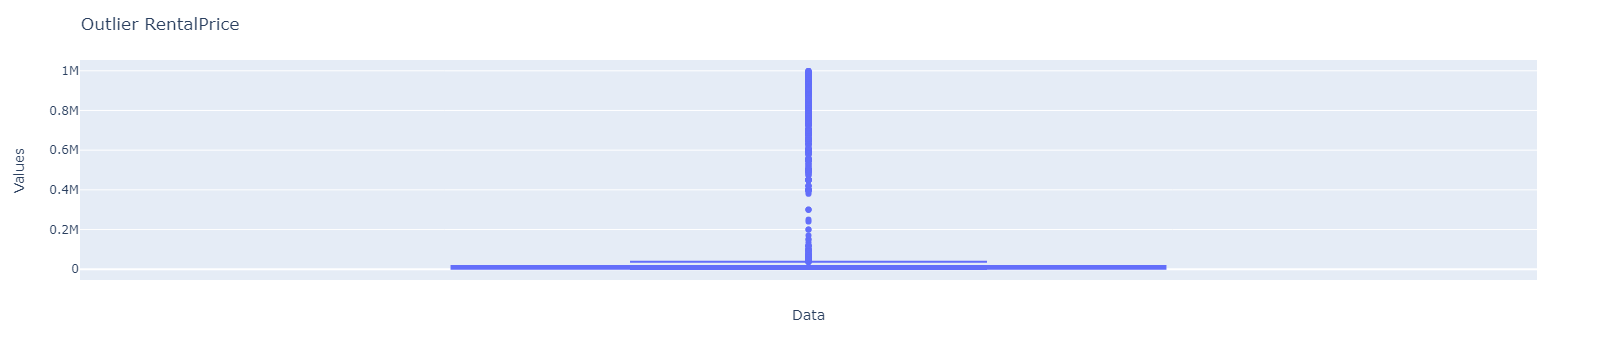

In [756]:
fig = px.box(
    df["listing.pricingInfo.rentalPrice"], y=df["listing.pricingInfo.rentalPrice"]
)
fig.update_layout(
    title="Outlier RentalPrice",
    xaxis=dict(title="Data"),
    yaxis=dict(title="Values"),
    boxmode="group",
    showlegend=False,
)
fig.show()

In [757]:
num_columns = [
    "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.yearlyIptu",
    "listing.usableAreas",
    "listing.totalAreas",
    "listing.pricingInfo.monthlyCondoFee",
    # "listing.unitFloor",
    # "listing.unitsOnTheFloor",
    # "listing.floors",
    # "listing.parkingSpaces",
]

df = remove_outliers(df, num_columns)

In [758]:
len(df["listing.pricingInfo.rentalPrice"].unique())

788

In [759]:
len(df["listing.pricingInfo.monthlyCondoFee"].unique())

1431

In [760]:
df[["listing.pricingInfo.monthlyCondoFee"]].sort_values(
    "listing.pricingInfo.monthlyCondoFee"
)

,listing.pricingInfo.monthlyCondoFee
50522,1.0
5176,1.0
50547,1.0
6653,1.0
7798,1.0
...,...
14266,2445.0
15873,2453.0
46779,2461.0
15951,2468.0


#### Save

In [761]:
df.to_csv("./dataZap_final.csv", sep=";", index=False)

#### Selecionar as features baseada na correlação

In [762]:
df = pd.read_csv("dataZap_final.csv", delimiter=";")
df.shape

(8795, 32)

In [763]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   listing.playground                   8795 non-null   bool   
 1   listing.address.neighborhood         8795 non-null   object 
 2   listing.parkingSpaces                8795 non-null   float64
 3   listing.bathtub                      8795 non-null   bool   
 4   listing.gym                          8795 non-null   bool   
 5   listing.floors                       8795 non-null   float64
 6   listing.barbgrill                    8795 non-null   bool   
 7   listing.totalAreas                   8795 non-null   float64
 8   listing.pricingInfo.yearlyIptu       8795 non-null   float64
 9   listing.bathrooms                    8795 non-null   int64  
 10  listing.fireplace                    8795 non-null   bool   
 11  listing.bedrooms              

In [764]:
df["listing.pricingInfo.yearlyIptu"] = df["listing.pricingInfo.yearlyIptu"].astype(
    float
)
df["listing.pricingInfo.monthlyCondoFee"] = df[
    "listing.pricingInfo.monthlyCondoFee"
].astype(float)
df["listing.usableAreas"] = df["listing.usableAreas"].astype(float)
df["listing.floors"] = df["listing.floors"].astype(float)
df["listing.parkingSpaces"] = df["listing.parkingSpaces"].astype(float)
df["listing.unitsOnTheFloor"] = df["listing.unitsOnTheFloor"].astype(float)
df["listing.unitFloor"] = df["listing.unitFloor"].astype(float)

df["listing.bedrooms"] = df["listing.bedrooms"].astype("category")
df["listing.bathrooms"] = df["listing.bathrooms"].astype("category")
df["listing.suites"] = df["listing.suites"].astype("category")
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].astype(
    "category"
)
df["listing.address.zone"] = df["listing.address.zone"].astype("category")
df["imvl_type"] = df["imvl_type"].astype("category")

In [765]:
df.isna().sum()

listing.playground                     0
listing.address.neighborhood           0
listing.parkingSpaces                  0
listing.bathtub                        0
listing.gym                            0
listing.floors                         0
listing.barbgrill                      0
listing.totalAreas                     0
listing.pricingInfo.yearlyIptu         0
listing.bathrooms                      0
listing.fireplace                      0
listing.bedrooms                       0
listing.pricingInfo.rentalPrice        0
listing.tenniscourt                    0
listing.garden                         0
listing.address.zone                   0
listing.usableAreas                    0
listing.soundproofing                  0
imvl_type                              0
listing.hottub                         0
listing.unitFloor                      0
listing.sauna                          0
listing.furnished                      0
listing.backyard                       0
listing.guestpar

<Axes: >

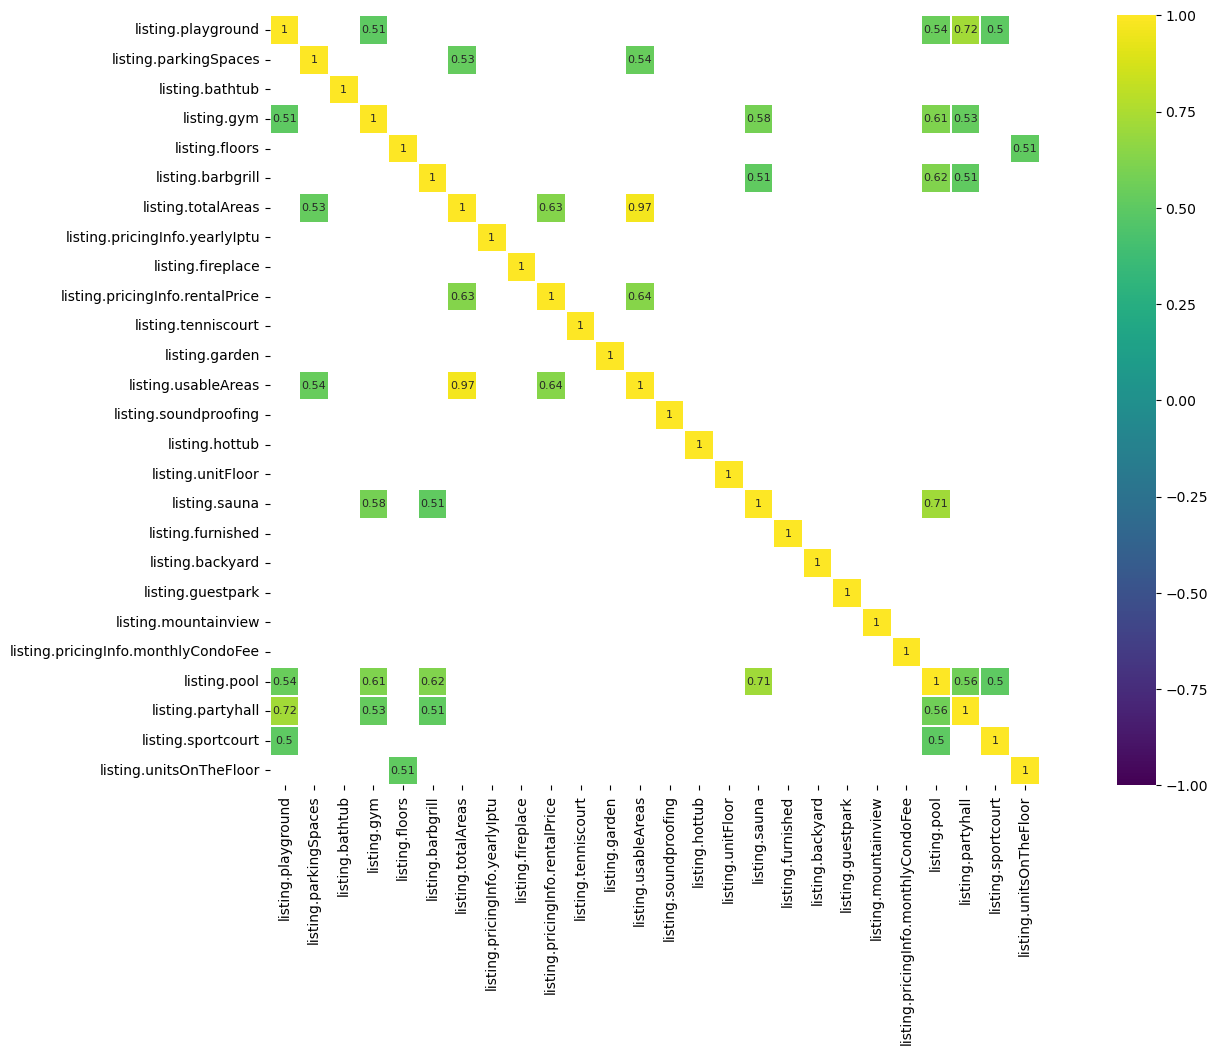

In [766]:
plt.subplots(figsize=(20, 10))
# sns.heatmap(df.corr(), cmap="RdBu", cbar=True, annot=True)
corr = df.corr()
sns.heatmap(
    corr[(corr >= 0.5) | (corr <= -0.4)],
    cmap="viridis",
    vmax=1.0,
    vmin=-1.0,
    linewidths=0.1,
    annot=True,
    annot_kws={"size": 8},
    square=True,
)

Valores com uma correlação considerável:

- listing_sauna x listing pool
- listing.playground x listing.sportcourt
- listing.pricinginfo.rentalPrice x listing.bedrooms
- listing.bathtub x listing.hottub
- listing.partyhall x listing.playground
- listing.pool x listing.barbgrill

Apesar de alguns terem valores de correlação alto, não considero retirar algumas colunas pois elas podem existir mesmo que a outra não exista, então é importante deixar pois são características diferentes.

#### Categorico para numérico

In [767]:
df.shape

(8795, 32)

In [769]:
bool_columns = [
    "listing.mountainview",
    "listing.sauna",
    "listing.sportcourt",
    "listing.hottub",
    "listing.fireplace",
    "listing.guestpark",
    "listing.soundproofing",
    "listing.gym",
    "listing.playground",
    "listing.partyhall",
    "listing.backyard",
    "listing.garden",
    "listing.barbgrill",
    "listing.furnished",
    "listing.tenniscourt",
    "listing.bathtub",
    "listing.pool",
]


cat_columns = [
    # "listing.address.neighborhood",
    "listing.address.zone",
    "imvl_type",
]

ordinal_cat_columns = [
    "listing.suites",
    "listing.bedrooms",
    "listing.bathrooms",
]

num_columns = [
    # "listing.pricingInfo.rentalPrice",
    "listing.pricingInfo.yearlyIptu",
    "listing.usableAreas",
    "listing.totalAreas",
    "listing.pricingInfo.monthlyCondoFee",
    "listing.unitFloor",
    "listing.unitsOnTheFloor",
    "listing.floors",
    "listing.parkingSpaces",
]

print(len(bool_columns))
print(len(cat_columns))
print(len(ordinal_cat_columns))
print(len(num_columns))

17
2
3
8


In [770]:
df["listing.bathrooms"].value_counts()

1     2905
2     2818
3     1758
4      760
5      327
6      128
0       52
7       30
8        8
9        4
11       3
10       1
12       1
Name: listing.bathrooms, dtype: int64

In [771]:
df[cat_columns]

,listing.address.zone,imvl_type
0,Zona Oeste,apartamentos
1,Zona Oeste,apartamentos
2,Zona Oeste,apartamentos
3,Zona Norte,apartamentos
4,Zona Norte,apartamentos
...,...,...
8790,Zona Oeste,apartamentos
8791,Zona Sul,apartamentos
8792,Zona Sul,apartamentos
8793,Zona Sul,apartamentos


In [772]:
df["listing.address.zone"].value_counts()

Zona Sul              3095
Zona Oeste            3028
Zona Norte            2175
Zona Central           174
Ilha do Governador     144
Bairros                106
normal                  73
Name: listing.address.zone, dtype: int64

In [773]:
df["imvl_type"].value_counts()

apartamentos           6452
cobertura              1121
casas                   530
quitinetes              298
casas-de-condominio     179
flat                    143
casas-de-vila            68
studio                    4
Name: imvl_type, dtype: int64

In [774]:
df["listing.address.neighborhood"].value_counts()

Copacabana                  874
Recreio Dos Bandeirantes    863
Barra da Tijuca             705
Ipanema                     547
Leblon                      488
                           ... 
Manguinhos                    1
Senador Vasconcelos           1
Santíssimo                    1
Parque Anchieta               1
 Pedra de Guaratiba           1
Name: listing.address.neighborhood, Length: 139, dtype: int64

In [775]:
# Categorical to numerical - cat_columns
freq = df["listing.address.neighborhood"].value_counts(normalize=True)
df["listing.address.neighborhood"] = df["listing.address.neighborhood"].map(freq)

In [776]:
df = encode_categorical_columns(df, cat_columns)
df

,listing.playground,listing.address.neighborhood,listing.parkingSpaces,listing.bathtub,listing.gym,listing.floors,listing.barbgrill,listing.totalAreas,listing.pricingInfo.yearlyIptu,listing.bathrooms,listing.fireplace,listing.bedrooms,listing.pricingInfo.rentalPrice,listing.tenniscourt,listing.garden,listing.usableAreas,listing.soundproofing,listing.hottub,listing.unitFloor,listing.sauna,listing.furnished,listing.backyard,listing.guestpark,listing.mountainview,listing.pricingInfo.monthlyCondoFee,listing.pool,listing.partyhall,listing.sportcourt,listing.unitsOnTheFloor,listing.suites,listing.address.zone_Bairros,listing.address.zone_Ilha do Governador,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,listing.address.zone_normal,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio
0,True,0.098124,1.0,False,True,1.0,True,140.0,200.0,2,False,2,6900.0,False,True,140.0,False,False,1.0,True,True,False,False,False,900.0,True,True,False,0.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,True,0.080159,1.0,False,True,1.0,True,100.0,250.0,2,False,2,3250.0,False,False,100.0,False,False,3.0,True,False,False,False,False,1500.0,True,True,False,0.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,True,0.080159,1.0,False,True,1.0,True,77.0,260.0,3,False,2,2800.0,False,True,77.0,False,False,0.0,True,False,False,False,False,1293.0,True,True,True,0.0,1.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
3,False,0.006367,0.0,False,False,3.0,False,60.0,0.0,1,False,2,1200.0,False,False,60.0,False,False,0.0,False,False,False,False,False,698.0,False,False,False,2.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,False,0.038999,1.0,False,False,1.0,False,70.0,210.0,2,False,2,2900.0,False,False,70.0,False,False,6.0,False,False,False,False,False,825.0,False,False,False,0.0,1.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8790,False,0.028425,2.0,False,True,1.0,True,100.0,66.0,1,False,2,1000.0,False,False,50.0,False,False,2.0,False,False,False,False,False,500.0,True,True,False,0.0,0.0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
8791,True,0.034906,2.0,False,False,1.0,False,124.0,250.0,2,False,3,5200.0,False,False,124.0,False,False,0.0,False,True,False,False,False,1296.0,False,True,False,0.0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
8792,False,0.028653,1.0,False,False,1.0,False,120.0,361.0,3,False,3,4700.0,False,False,120.0,False,False,0.0,False,False,False,False,False,968.0,False,False,False,0.0,1.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
8793,False,0.099375,0.0,False,False,1.0,False,30.0,60.0,2,False,1,1400.0,False,False,30.0,False,False,0.0,False,False,False,False,False,480.0,False,False,False,0.0,0.0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0


In [777]:
df[bool_columns]

,listing.mountainview,listing.sauna,listing.sportcourt,listing.hottub,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.playground,listing.partyhall,listing.backyard,listing.garden,listing.barbgrill,listing.furnished,listing.tenniscourt,listing.bathtub,listing.pool
0,False,True,False,False,False,False,False,True,True,True,False,True,True,True,False,False,True
1,False,True,False,False,False,False,False,True,True,True,False,False,True,False,False,False,True
2,False,True,True,False,False,False,False,True,True,True,False,True,True,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8790,False,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,True
8791,False,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False
8792,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8793,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [778]:
df[bool_columns] = df[bool_columns].astype(int)
df[bool_columns]

,listing.mountainview,listing.sauna,listing.sportcourt,listing.hottub,listing.fireplace,listing.guestpark,listing.soundproofing,listing.gym,listing.playground,listing.partyhall,listing.backyard,listing.garden,listing.barbgrill,listing.furnished,listing.tenniscourt,listing.bathtub,listing.pool
0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,1
1,0,1,0,0,0,0,0,1,1,1,0,0,1,0,0,0,1
2,0,1,1,0,0,0,0,1,1,1,0,1,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8790,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1
8791,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
8792,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8793,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Explicar que o categorical columns aumenta muito a dimensionalidade e o desempenho do modelo e por isso foi utilizado outros métodos para transformar os dados categóricos em numericos

In [779]:
le = LabelEncoder()

for categorical in ordinal_cat_columns:
    df[categorical] = le.fit_transform(df[categorical])

#### Normalização dos Dados

In [780]:
df.head(2)

,listing.playground,listing.address.neighborhood,listing.parkingSpaces,listing.bathtub,listing.gym,listing.floors,listing.barbgrill,listing.totalAreas,listing.pricingInfo.yearlyIptu,listing.bathrooms,listing.fireplace,listing.bedrooms,listing.pricingInfo.rentalPrice,listing.tenniscourt,listing.garden,listing.usableAreas,listing.soundproofing,listing.hottub,listing.unitFloor,listing.sauna,listing.furnished,listing.backyard,listing.guestpark,listing.mountainview,listing.pricingInfo.monthlyCondoFee,listing.pool,listing.partyhall,listing.sportcourt,listing.unitsOnTheFloor,listing.suites,listing.address.zone_Bairros,listing.address.zone_Ilha do Governador,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,listing.address.zone_normal,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio
0,1,0.098124,1.0,0,1,1.0,1,140.0,200.0,2,0,2,6900.0,0,1,140.0,0,0,1.0,1,1,0,0,0,900.0,1,1,0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,1,0.080159,1.0,0,1,1.0,1,100.0,250.0,2,0,2,3250.0,0,0,100.0,0,0,3.0,1,0,0,0,0,1500.0,1,1,0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [781]:
df = standardize_columns(df, num_columns)
df.head(2)

,listing.playground,listing.address.neighborhood,listing.parkingSpaces,listing.bathtub,listing.gym,listing.floors,listing.barbgrill,listing.totalAreas,listing.pricingInfo.yearlyIptu,listing.bathrooms,listing.fireplace,listing.bedrooms,listing.pricingInfo.rentalPrice,listing.tenniscourt,listing.garden,listing.usableAreas,listing.soundproofing,listing.hottub,listing.unitFloor,listing.sauna,listing.furnished,listing.backyard,listing.guestpark,listing.mountainview,listing.pricingInfo.monthlyCondoFee,listing.pool,listing.partyhall,listing.sportcourt,listing.unitsOnTheFloor,listing.suites,listing.address.zone_Bairros,listing.address.zone_Ilha do Governador,listing.address.zone_Zona Central,listing.address.zone_Zona Norte,listing.address.zone_Zona Oeste,listing.address.zone_Zona Sul,listing.address.zone_normal,imvl_type_apartamentos,imvl_type_casas,imvl_type_casas-de-condominio,imvl_type_casas-de-vila,imvl_type_cobertura,imvl_type_flat,imvl_type_quitinetes,imvl_type_studio
0,1,0.098124,0.033333,0,1,0.005714,1,0.454248,0.252207,2,0,2,6900.0,0,1,0.351351,0,0,0.02,1,1,0,0,0,0.363968,1,1,0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,1,0.080159,0.033333,0,1,0.005714,1,0.323529,0.315259,2,0,2,3250.0,0,0,0.243243,0,0,0.06,1,0,0,0,0,0.606883,1,1,0,0.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0


#### Save 2

In [782]:
df.to_csv("./dataZap_normalized.csv", sep=";", index=False)

### Divisão Treino e Teste

In [847]:
df = pd.read_csv("dataZap_normalized.csv", delimiter=";")
df.shape

(8795, 45)

In [848]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8795 entries, 0 to 8794
Data columns (total 45 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   listing.playground                       8795 non-null   int64  
 1   listing.address.neighborhood             8795 non-null   float64
 2   listing.parkingSpaces                    8795 non-null   float64
 3   listing.bathtub                          8795 non-null   int64  
 4   listing.gym                              8795 non-null   int64  
 5   listing.floors                           8795 non-null   float64
 6   listing.barbgrill                        8795 non-null   int64  
 7   listing.totalAreas                       8795 non-null   float64
 8   listing.pricingInfo.yearlyIptu           8795 non-null   float64
 9   listing.bathrooms                        8795 non-null   int64  
 10  listing.fireplace                        8795 no

In [849]:
X = df.drop(["listing.pricingInfo.rentalPrice"], axis=1)
y = df["listing.pricingInfo.rentalPrice"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Regressões

#### Regressão Linear

With pd.dummies categorizer / onehotencoder

In [850]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)

In [851]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.6263
MAE 		: 2276.9425
MSE 		: 11542275.2289
RMSE 		: 3397.3924


In [798]:
y_test = np.array(list(y_test))
y_pred = np.array(y_pred)
df_final = pd.DataFrame({"Actual": y_test.flatten(), "Predicted": y_pred.flatten()})
df_final

,Actual,Predicted
0,1800.0,2472.262523
1,1200.0,414.466536
2,4500.0,13372.920563
3,19990.0,11828.616091
4,4500.0,5066.274470
...,...,...
1754,2500.0,2912.656614
1755,10000.0,3661.342450
1756,8500.0,5676.830541
1757,2200.0,917.943647


#### Regressão Ridge

In [856]:
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_test)

In [857]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.6253
MAE 		: 2278.303
MSE 		: 11571309.5765
RMSE 		: 3401.6628


#### Regressão Lasso

In [858]:
lasso_model = Lasso(alpha=1.0)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)

In [859]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.6255
MAE 		: 2275.2827
MSE 		: 11565979.4555
RMSE 		: 3400.8792


#### Regressão ElasticNet

In [860]:
elasticnet_model = ElasticNet(alpha=1.0)
elasticnet_model.fit(X_train, y_train)
y_pred = elasticnet_model.predict(X_test)

In [861]:
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.4712
MAE 		: 2516.1979
MSE 		: 16332191.0491
RMSE 		: 4041.3106


#### Regressão Logística

Não é possível fazer regressão logística com esse dataset

#### Regressão com KNN

In [862]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [863]:
y_pred = knn_model.predict(X_test)
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.6809
MAE 		: 1640.5308
MSE 		: 9856079.0878
RMSE 		: 3139.4393


#### Regressão com Árvore

In [864]:
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)

DecisionTreeRegressor()

In [865]:
y_pred = decision_tree_model.predict(X_test)
evaluate_metrics(y_test, y_pred)

Model testing performance:
--------------------------
R2_score 	: 0.6692
MAE 		: 1470.7642
MSE 		: 10215804.4364
RMSE 		: 3196.2172


#### Resultado Final das Regressões

In [866]:
linear_metrics = evaluate_metrics_cv(linear_model, X_train, y_train, X_test, y_test)
# logistic_metrics = evaluate_metrics_cv(logistic_model, X_train, y_train, X_test, y_test)
knn_metrics = evaluate_metrics_cv(knn_model, X_train, y_train, X_test, y_test)
decision_tree_metrics = evaluate_metrics_cv(
    decision_tree_model, X_train, y_train, X_test, y_test
)
ridge_metrics = evaluate_metrics_cv(ridge_model, X_train, y_train, X_test, y_test)
lasso_metrics = evaluate_metrics_cv(lasso_model, X_train, y_train, X_test, y_test)
elasticnet_metrics = evaluate_metrics_cv(
    elasticnet_model, X_train, y_train, X_test, y_test
)

In [867]:
data = {"Model": [], "Metric": [], "without CV": [], "CV": []}

for model_metrics in [
    linear_metrics,
    ridge_metrics,
    lasso_metrics,
    elasticnet_metrics,
    knn_metrics,
    decision_tree_metrics,
]:
    model_name, *metrics = model_metrics
    for metric_name, value in zip(
        [
            "R2 Score",
            "Cross-Validated R2 Score",
            "Root Mean Squared Error",
            "Cross-Validated Root Mean Squared Error",
            "Mean Absolute Error",
            "Cross-Validated Mean Absolute Error",
        ],
        metrics,
    ):
        data["Model"].append(model_name)
        data["Metric"].append(metric_name)
        data["without CV"].append(
            value
            if metric_name != "Cross-Validated R2 Score"
            and metric_name != "Cross-Validated Root Mean Squared Error"
            and metric_name != "Cross-Validated Mean Absolute Error"
            else ""
        )
        data["CV"].append(
            value
            if metric_name == "Cross-Validated R2 Score"
            or metric_name == "Cross-Validated Root Mean Squared Error"
            or metric_name == "Cross-Validated Mean Absolute Error"
            else "-"
        )

df_evaluation = pd.DataFrame(data)
df_evaluation

,Model,Metric,without CV,CV
0,Linear Regression,R2 Score,0.626259,-
1,Linear Regression,Cross-Validated R2 Score,,0.657669
2,Linear Regression,Root Mean Squared Error,3397.392416,-
3,Linear Regression,Cross-Validated Root Mean Squared Error,,3430.779146
4,Linear Regression,Mean Absolute Error,2276.942542,-
5,Linear Regression,Cross-Validated Mean Absolute Error,,2289.44776
6,Ridge,R2 Score,0.625318,-
7,Ridge,Cross-Validated R2 Score,,0.657775
8,Ridge,Root Mean Squared Error,3401.662766,-
9,Ridge,Cross-Validated Root Mean Squared Error,,3430.213764
